# Analyzing iMessage Conversations with GF

Load chat data from ~/username/Library/Messages/chat.db into sqlite to use the native macOS sqlite to open up the chat.db type: 
`sqlite3 /Users/username/Library/Messages/chat.db` 

Three sections: 
* extracting the data
1. .tables
* transforming (cleaning) the data
* getting insights into data 

In [113]:
import sqlite3
import pandas as pd
import datetime
import emoji
import bokeh
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot') # do i need this? 
sns.set_palette('Set2') # do i need this? 

## Load chat data in sqlite

In [114]:
# connect to sqlite chat database in user directory
sqlite_db = sqlite3.connect('/Users/adamstueckrath/Library/Messages/chat.db')

In [115]:
# get a “cursor” to execute sql commands
sql_command = sqlite_db.cursor()

In [116]:
# sql query -> need to expand and give description 
query = '''
        SELECT * FROM chat
        INNER JOIN handle
            ON chat.chat_identifier = handle.id
        INNER JOIN chat_handle_join
            ON  handle.ROWID = chat_handle_join.handle_id
        INNER JOIN message
            ON message.handle_id = chat_handle_join.handle_id
        WHERE (chat_identifier LIKE '%8385'
            OR chat_identifier LIKE '%622%')
            AND length(message.text) > 0
        '''

# execute sql query in sqlite3 
table = sql_command.execute(query)

# get list of column names. example: ['ROWID', 'account', 'account_guid']
# table.description is description of columns
column_names = list(map(lambda x: x[0], table.description))

# load sql table into pandas dataframe and pass in the column names
chat_df = pd.DataFrame(table.fetchall(), columns=column_names)

In [117]:
# List all of the tables in chat.db 
# Investigate data
#***MAKE NOTE OF STORED READ RECEIPTS "is_read"*** -> user expected behavior?? Maybe, maybe not?

In [118]:
# display iMessage chat dataframe head() 
chat_df.tail(2)

,ROWID,guid,style,state,account_id,properties,chat_identifier,service_name,room_name,account_login,...,associated_message_range_length,time_expressive_send_played,message_summary_info,ck_sync_state,ck_record_id,ck_record_change_tag,destination_caller_id,sr_ck_sync_state,sr_ck_record_id,sr_ck_record_change_tag
116044,3,iMessage;-;+12246228385,45,3,3AF46D92-D26E-4FE7-AAE0-12EB5480563D,b'bplist00\xd3\x01\x02\x03\x04\x05\x06_\x10\x1...,+12246228385,iMessage,None,E:stueckrath.adam@gmail.com,...,0,0,None,0,None,None,+15154180987,0,None,None
116045,3,iMessage;-;+12246228385,45,3,3AF46D92-D26E-4FE7-AAE0-12EB5480563D,b'bplist00\xd3\x01\x02\x03\x04\x05\x06_\x10\x1...,+12246228385,iMessage,None,E:stueckrath.adam@gmail.com,...,0,0,None,0,,,+15154180987,0,,


## Transform Data

In [119]:
# select columns from chat dataframe
column_list = ['id','is_from_me','text','cache_has_attachments','date']
chat_df = chat_df[column_list]

# show the last 5 rows with selected columns
chat_df.tail()

,id,is_from_me,text,cache_has_attachments,date
116041,+12246228385,1,You like that,0,545702491681126592
116042,+12246228385,0,That’s terrifying,0,545702509579491584
116043,+12246228385,0,I’m not flying home,0,545702531336244096
116044,+12246228385,1,Bye,0,545702558536049344
116045,+12246228385,0,Ok,0,545702595465151808


In [120]:
# house cleaning - drop duplicate columns from dataframe
chat_df = chat_df.loc[:,~chat_df.columns.duplicated()]

# rename columns 
chat_df.rename(columns={'id':'phone_number','is_from_me':'is_sent', 
                        'text':'message','cache_has_attachments':'is_picture', 
                        'date':'message_date'}, inplace=True)

# show the last 5 rows with selected columns
chat_df.tail()

,phone_number,is_sent,message,is_picture,message_date
116041,+12246228385,1,You like that,0,545702491681126592
116042,+12246228385,0,That’s terrifying,0,545702509579491584
116043,+12246228385,0,I’m not flying home,0,545702531336244096
116044,+12246228385,1,Bye,0,545702558536049344
116045,+12246228385,0,Ok,0,545702595465151808


In [121]:
# add column is_received column
# it is the opposite of is_sent. exmaple: is_sent = 1, is_received = 0
# axis=1 defines that function is to be applied on each row
chat_df['is_received'] = chat_df.apply(lambda row: int(not bool(row.is_sent)), axis=1)

In [122]:
# transform phone_number df.apply (lambda row: label_race (row),axis=1)
def clean_phone_numb(number):
    if bool(number):
        return '515-418-0987'
    return '224-622-8385'

chat_df['phone_number'] = chat_df.apply(lambda row: clean_phone_numb(row.is_sent), axis=1)

In [123]:
# transform message_date column into datetime.datetime object 
# convert numpy.int64 into pandas time ojbect 
# convert time object into datetime.datetime
chat_df['message_date'] = pd.to_datetime(chat_df['message_date'], unit='ns') 
chat_df['message_date'] = chat_df.apply(lambda row: row.message_date.to_pydatetime(warn=False),axis=1)
chat_df['message_date'] = chat_df.apply(lambda row: row.message_date + pd.DateOffset(years=30),axis=1)

chat_df.tail()

,phone_number,is_sent,message,is_picture,message_date,is_received
116041,515-418-0987,1,You like that,0,2017-04-18 00:01:31.681126,0
116042,224-622-8385,0,That’s terrifying,0,2017-04-18 00:01:49.579491,1
116043,224-622-8385,0,I’m not flying home,0,2017-04-18 00:02:11.336244,1
116044,515-418-0987,1,Bye,0,2017-04-18 00:02:38.536049,0
116045,224-622-8385,0,Ok,0,2017-04-18 00:03:15.465151,1


In [124]:
# add name column 
def add_name_col(phone_number):
    if phone_number == '515-418-0987':
        return 'Adam'
    return 'Bridget'

chat_df['name'] = chat_df.apply(lambda row: add_name_col(row.phone_number), axis=1)

## Data Visualization

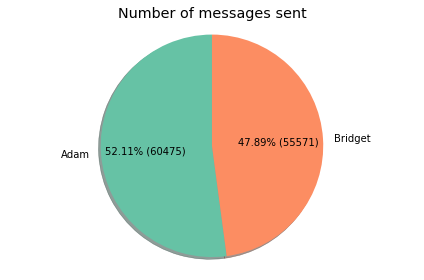

In [125]:
# pie chart for the number of messages sent between us
labels = ['Adam', 'Bridget']
values = [chat_df['is_sent'].value_counts()[1], 
         chat_df['is_received'].value_counts()[1]]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

fig1, ax1 = plt.subplots()
ax1.set_title('Number of messages sent')
ax1.pie(values, labels=labels, autopct=make_autopct(values), shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.show()

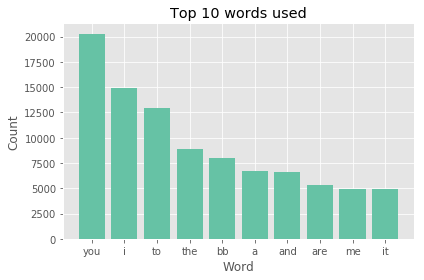

In [126]:
# get counts of every word using .lower() 
word_counts = chat_df.message.str.lower().str.split(expand=True).stack().value_counts()
word_count_df = word_counts.to_frame().reset_index()
word_count_df.rename(columns={'index':'word',0:'count'}, inplace=True)
word_count_df.sort_values('count', ascending=False, inplace=True)

# need to drop the count for spaces (' ') --> it's actually for pictures!! need to re-work logic
word_count_df.drop(word_count_df.index[[8]], inplace=True)
word_count_df.reset_index(drop=True, inplace=True)

# this is for plotting
# bar chart for top 10 words sent between us
bar_values = word_count_df[:10]
labels = bar_values['word'].values.tolist()
values = bar_values['count'].values.tolist()
x_pos = [i for i, _ in enumerate(labels)]

plt.bar(x_pos, values)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 10 words used')
plt.xticks(x_pos, labels)
plt.tight_layout()
plt.show()

In [127]:
# Dictionary storing emoji counts 
import collections
import re
emoji_count = collections.defaultdict(int) 
for i in chat_df['message']:
    for emoji in re.findall(r'[\U0001f300-\U0001f650]|[\u2000-\u3000]|[\U0001f3fb-\U0001f3ff]?|[1F4AA]', i):     
        emoji_count[emoji] += 1
#adam_test = sorted(emoji_count.items(), key=lambda x: x[1], reverse=True)

emoji_pattern = re.compile(
    u"(\ud83d[\ude00-\ude4f])|"  # emoticons
    u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
    u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
    u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
    u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
    "+", flags=re.UNICODE)

#char_with_modifier = re.compile(r'(.[\U0001f3fb-\U0001f3ff]?)')
#print (collections.Counter(char_with_modifier.findall(emoji_string)))

In [128]:

# get top day and number of messages
# get total # of words, and messages 

In [129]:
def group_by_date(date_column, *args):
    return date_column.groupby(list(args)).agg('count')

months_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
def mapper(month):
    return months_map[month]

bridget = chat_df[chat_df.is_received == 1]
adam = chat_df[chat_df.is_sent == 1]

# Get message by weekday
#adam = adam['message_date'].groupby([adam.message_date.dt.weekday]).agg('count')
#bridget = bridget['message_date'].groupby([bridget.message_date.dt.weekday]).agg('count')

# Get message by month
adam = group_by_date(adam['message_date'], adam.message_date.dt.year, adam.message_date.dt.month)
bridget = group_by_date(bridget['message_date'], bridget.message_date.dt.year, bridget.message_date.dt.month)
bridget = pd.DataFrame({'month':bridget.index, 'count':bridget.values}) 
adam = pd.DataFrame({'month':adam.index, 'count':adam.values}) 
adam['month'] = [mapper(x[1]) for x in adam.month.values]
bridget['month'] = [mapper(x[1]) for x in bridget.month.values]


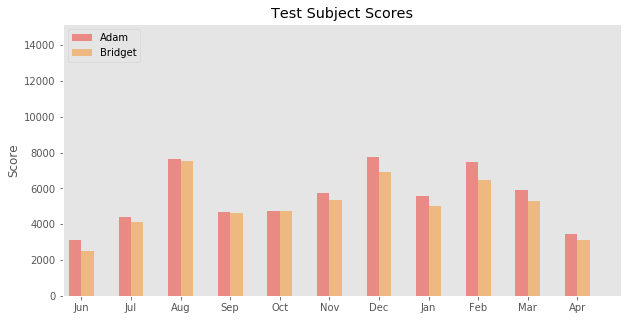

In [130]:
# Setting the positions and width for the bars
pos = list(range(len(adam['month']))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        adam['count'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label=adam['month']) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        bridget['count'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F78F1E', 
        # with label the second value in first_name
        label=adam['month']) 


# Set the y axis label
ax.set_ylabel('Score')

# Set the chart's title
ax.set_title('Test Subject Scores')

# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(bridget['month'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(bridget['count'] + adam['count'])] )

# Adding the legend and showing the plot
plt.legend(['Adam', 'Bridget'], loc='upper left')
plt.grid()
plt.show()


In [197]:
from bokeh.core.properties import value
from bokeh.io import show, output_file, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import dodge
output_notebook(resources=None, verbose=False, hide_banner=True )
adam['count_b'] = pd.Series(bridget['count'])
source = ColumnDataSource(data=adam.to_dict(orient='list'))

p = figure(x_range=adam['month'].tolist(), y_range=(0,max(adam['count'].tolist())+3000), plot_height=350, title="Fruit Counts by Year",
           toolbar_location=None, tools="")

p.vbar(x=dodge('month', -0.20, range=p.x_range), top='count', width=0.30, source=source,
       color="#c9d9d3", legend=value("Adam"))

p.vbar(x=dodge('month',  0.15,  range=p.x_range), top='count_b', width=0.30, source=source,
       color="#718dbf", legend=value("Bridget"))


p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"
p.yaxis.axis_label = "Number of messages"
p.xaxis.axis_label = "Months"
show(p)

